<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/explore_nbs/09_vision_augment_experiments_profile_CPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#colab
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [3]:
#colab
%%bash
pip install fastai2 --upgrade

In [4]:
#colab
%%bash
pip install git+https://github.com/butchland/fastai_xla_extensions

  Cloning https://github.com/butchland/fastai_xla_extensions to /tmp/pip-req-build-8yam3l_7
  Created wheel for fastai-xla-extensions: filename=fastai_xla_extensions-0.0.1-cp36-none-any.whl size=10373 sha256=640b6bf337aaa1a578919222a5d64613d345f196466d11a9e3e570d3b51a829b
  Stored in directory: /tmp/pip-ephem-wheel-cache-tg_9i_of/wheels/3c/d5/c1/7a96c15b4e74b5d1ec0bc6c29fcaf36501791ce2d9a88a8cea
Successfully built fastai-xla-extensions


  Running command git clone -q https://github.com/butchland/fastai_xla_extensions /tmp/pip-req-build-8yam3l_7


In [5]:
#colab
%%bash
pip install git+https://github.com/butchland/my_timesaver_utils

  Cloning https://github.com/butchland/my_timesaver_utils to /tmp/pip-req-build-va99vvbv
  Created wheel for my-timesaver-utils: filename=my_timesaver_utils-0.0.1-cp36-none-any.whl size=9098 sha256=9cefba74a94b9ed64efa530c558029d7aab2816972db5636fb32c96d52129031
  Stored in directory: /tmp/pip-ephem-wheel-cache-437oa4ac/wheels/ca/6d/f4/ad01bd19bc4c102a3851d9c636dc2a2031d97b98cb9a73effa
Successfully built my-timesaver-utils


  Running command git clone -q https://github.com/butchland/my_timesaver_utils /tmp/pip-req-build-va99vvbv


In [ ]:
#colab
# install pytorch xla
# VERSION = "20200707"  #@param ["1.5" , "20200516","20200707", "nightly"]
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION

In [6]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

KeyError: ignored

In [8]:
%%bash
pip freeze | grep torch
pip freeze | grep fastai2

torch==1.6.0+cu101
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.7.0+cu101
fastai2==0.0.21


In [9]:
import fastai_xla_extensions.core

In [10]:
from fastai2.vision.all import *

In [11]:
from my_timesaver_utils.profiling import *

In [12]:
path = untar_data(URLs.PETS)/'images'

In [13]:
Path.BASE_PATH = path; path.ls()

(#7393) [Path('german_shorthaired_97.jpg'),Path('havanese_150.jpg'),Path('Bombay_164.jpg'),Path('Birman_185.jpg'),Path('leonberger_139.jpg'),Path('miniature_pinscher_124.jpg'),Path('saint_bernard_125.jpg'),Path('Birman_80.jpg'),Path('pug_47.jpg'),Path('havanese_77.jpg')...]

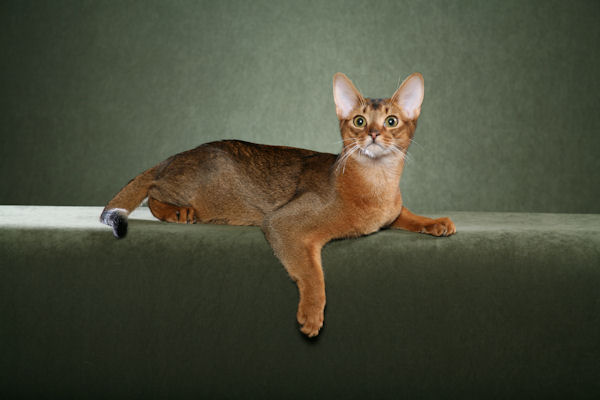

In [14]:
img = PILImage.create(path/'Abyssinian_1.jpg');img

In [15]:
img.shape

(400, 600)

In [16]:
resize = Resize(size=200)

In [17]:
img2 = resize(img,split_idx=0)
img2.shape

(200, 200)

In [18]:
timg2 = TensorImage(array(img2)).permute(2,0,1).float()/255.; timg2.shape

torch.Size([3, 200, 200])

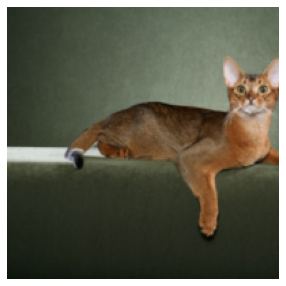

In [19]:
show_image(timg2)

In [20]:
default_device()

device(type='cpu')

In [21]:
torch.cuda.is_available()

False

In [22]:
def batch_ex(bs, device): return TensorImage(timg2[None].to(device).expand(bs, *timg2.shape))

In [23]:
b768_img = batch_ex(768, default_device()); (b768_img.shape, b768_img.device)

(torch.Size([768, 3, 200, 200]), device(type='cpu'))

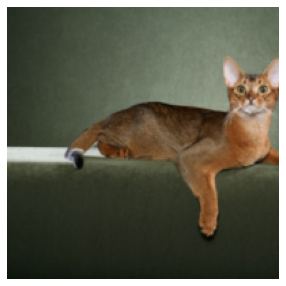

In [24]:
show_image(b768_img[-1].to(torch.device('cpu')));

### Add transform

In [25]:
flip_tfm = Flip(p=1.0); flip_tfm

AffineCoordTfm:
encodes: (TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
(TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: 

### Add profilers 

In [26]:
F.grid_sample = profile_call(F.grid_sample)

In [27]:
@profile_call
def mtest(b_img):
    #set_trace()
    new_b_img = flip_tfm(b_img)
    return new_b_img

### Profile transform calls

In [28]:
clear_prof_data()

In [29]:
%%time
new_b768_img = mtest(b768_img)

CPU times: user 1.18 s, sys: 431 ms, total: 1.61 s
Wall time: 1.66 s


In [30]:
print_prof_data()

Function grid_sample called 1 times.
Execution time max: 0.844, average: 0.844
Function mtest called 1 times.
Execution time max: 1.656, average: 1.656


In [31]:
(new_b768_img.shape, new_b768_img.device)

(torch.Size([768, 3, 200, 200]), device(type='cpu'))

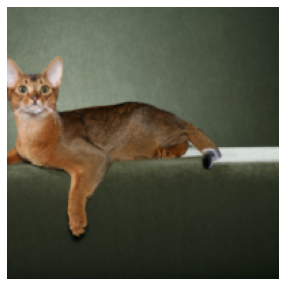

In [32]:
show_image(new_b768_img[-1].to(torch.device('cpu')));

In [33]:
clear_prof_data()

In [34]:
%%time
for i in range(10): new_b768_img = mtest(b768_img)

CPU times: user 12 s, sys: 296 ms, total: 12.3 s
Wall time: 12.3 s


In [35]:
print_prof_data()

Function grid_sample called 10 times.
Execution time max: 0.842, average: 0.821
Function mtest called 10 times.
Execution time max: 1.450, average: 1.227
